In [1]:
# Biblotecas de manipulação de dados
import numpy as np
import pandas as pd
# Bibliotecas de visualização
import seaborn as sns
import matplotlib.pyplot as plt
# Testes estatísticos
from scipy.stats import ttest_ind
# Bibliotecas Locais
from carga import *
from tratamentos import *
from categorizacao import *

pfEnade = doCarga('microdados_enade_2019.txt')
# TRATAMENTOS 
pfEnade = doIdade(pfEnade)
pfEnade = doNota(pfEnade)
pfEnade = doVazios(pfEnade)
pfEnade = doPublicoPrivada(pfEnade)
pfEnade = doHumanasExatas(pfEnade)
pfEnade = doRenda(pfEnade)
pfEnade = doMigracao(pfEnade)
# TRATAMENTOS - Dicionários
pfEnade = doRenda(pfEnade)
#pfEnade['Renda'].value_counts().sort_index()
# pfEnade.isna().sum()    # Mostra se há vazios
pfEnade = doEscolaridade(pfEnade)

In [26]:
pfEnade.count()

CO_GRUPO            389656
CO_UF_CURSO         389656
TP_SEXO             389656
NT_GER              389656
QE_I04              389656
QE_I05              389656
QE_I08              389656
QE_I16              389656
QE_I17              389656
QE_I23              389656
Indice              389656
Tempo               389656
Publica             389656
Exatas              389656
Renda               389656
RendaDIC            389656
Migrado             389656
EPai                389656
EscolaridadeDesc    389656
dtype: int64

In [2]:
pfEnade = pfEnade.query('QE_I08 != " "')
pfEnade = pfEnade.query('QE_I23 != " "')
pfEnade['NT_GER'].fillna(0, inplace=True)

In [ ]:
tmp = pfEnade.query('QE_I08 == " "')
pfEnade = pfEnade.query('QE_I08 != " "')
tmp.head()

In [ ]:
# Renda Familiar X Nota
tmp = pfEnade.groupby('QE_I08')['NT_GER'].agg(['mean', 'std', 'count']).sort_index()
tmp.index = pd.Series(tmp.index).replace(doRendaDIC())
tmp.index.name = 'Qual a renda total de sua família, incluindo seus rendimentos?'
tmp 

In [ ]:
# Horas de Estudo X Renda Familiar
tmp = pfEnade.groupby('QE_I23')['NT_GER'].agg(['mean', 'std', 'count']).sort_index()
tmp.index = pd.Series(tmp.index).replace(doHEstudoDIC())
tmp.index.name = 'Quantas horas por semana, aproximadamente, você dedicou aos estudos, excetuando as horas de aula?'
tmp 

In [ ]:
# CORRELAÇÂO entre os grupos de horas de estudos
lista_de_listas = []
valores = sorted(pfEnade['QE_I23'].dropna().unique().tolist())
for i in valores:
    lista_de_listas.append([])
    for j in valores:
        t_res = ttest_ind(pfEnade.query(f'QE_I23 == @i')['NT_GER'], pfEnade.query(f'QE_I23 == @j')['NT_GER'])
        lista_de_listas[-1].append(t_res.pvalue)

valores = pd.Series(valores).replace(doHEstudoDIC())
tmp = pd.DataFrame(lista_de_listas, index=valores, columns=valores)    

sns.heatmap(tmp, cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9))

In [ ]:
# AGRUPANDO Renda X Horas de Estudo X Nota Média
tmp = pfEnade.groupby(['QE_I08', 'QE_I23'])['NT_GER'].agg(['mean']).unstack()
    
tmp.index = pd.Series(tmp.index).replace(doRendaDIC())
tmp.index.name = 'Qual a renda total de sua família, incluindo seus rendimentos?'

tmp.columns = tmp.columns.droplevel(0)
tmp.columns = pd.Series(tmp.columns).replace(doHEstudoDIC())
tmp.columns.name = 'Quantas horas por semana, aproximadamente, você dedicou aos estudos, excetuando as horas de aula?'
    
tmp 

In [ ]:
tmp = pfEnade.groupby(['QE_I08', 'QE_I23'])['NT_GER'].agg(['mean']).unstack() #.where(pfEnade.QE_I08 != ' ')
    
#tmp.index = pd.Series(tmp.index).replace(doRendaDIC())
tmp.index.name = 'Qual a renda total de sua família, incluindo seus rendimentos?'

tmp.columns = tmp.columns.droplevel(0)

#tmp.columns = pd.Series(tmp.columns).replace(doHEstudoDIC())
tmp.columns.name = 'Quantas horas por semana, aproximadamente, você dedicou aos estudos, excetuando as horas de aula?'
    
ax = tmp.plot(figsize=(15,5)) 
ax.set_title('Nota X Renda X Horas', fontsize=20)

textoRenda = ""
for key, value in doRendaDIC().items():
    textoRenda = textoRenda + "{k} : {v}\n".format(k=key, v=value)
ax.text(0.05, 0.6, textoRenda, transform=ax.transAxes, fontsize=8)


textoEstudo = ""
for key, value in doRendaDIC().items():
    textoEstudo = textoEstudo + "{k} : {v}\n".format(k=key, v=value)
ax.legend(textoEstudo)


In [ ]:
sns.heatmap(data=tmp, cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9), )

In [ ]:
# Gênero X Nota
tmp = pfEnade.groupby('TP_SEXO')['NT_GER'].agg(['mean', 'std', 'count']).sort_index()
tmp.index = pd.Series(tmp.index).replace(doSexoDIC())
tmp.index.name = 'Sexo'
tmp 

In [ ]:
# Gênero X Nota
tmp.div(tmp.iloc[1])

In [ ]:
# Sexo X Renda
SxR = pfEnade.groupby(['TP_SEXO', 'QE_I08'])['NT_GER'].agg(['count']).unstack()
    
SxR.index = pd.Series(SxR.index).replace(doSexoDIC())
SxR.index.name = 'Sexo'

SxR.columns = SxR.columns.droplevel(0)
SxR.columns = pd.Series(SxR.columns).replace(doRendaDIC())
SxR.columns.name = 'Qual a renda total de sua família, incluindo seus rendimentos?'
    
SxR 

In [ ]:
# BUG
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Título Plot')
SxR.filter(items=['TP_SEXO', 'QE_I08', 'NT_GER'])\
    .groupby(['TP_SEXO', 'QE_I08'])\
    .mean().sort_values(by='NT_GER', ascending=False)\
    .unstack().plot(ax=ax)

In [ ]:
SxR.div(SxR.iloc[1])

In [ ]:
# Migrado X Renda X Nota
MxR = pfEnade.groupby(['Migrado', 'QE_I08'])['NT_GER'].agg(['count']).unstack()
    
MxR.index = pd.Series(MxR.index).replace(doMigradoDIC())
MxR.index.name = 'Migrado'

MxR.columns = MxR.columns.droplevel(0)
MxR.columns = pd.Series(MxR.columns).replace(doRendaDIC())
MxR.columns.name = 'Qual a renda total de sua família, incluindo seus rendimentos?'
    
MxR 

In [11]:
pfEnade.query('NT_GER == 0').head

<bound method NDFrame.head of        CO_GRUPO  CO_UF_CURSO TP_SEXO  NT_GER QE_I04 QE_I05 QE_I08  QE_I16  \
2          5710           51       M     0.0      E      E      E      51   
40         5710           51       F     0.0      A      D      A      51   
61           17           51       M     0.0      E      D      E      51   
62           17           51       M     0.0      D      F      E      51   
66           17           51       M     0.0      D      E      C      51   
...         ...          ...     ...     ...    ...    ...    ...     ...   
433798     5902           33       M     0.0      D      E      E      33   
433808     5902           33       M     0.0      B      B      G      31   
433812     5902           33       M     0.0      E      E      A      26   
433872     5710           33       M     0.0      D      F      E      33   
433891     5710           33       M     0.0      D      E      E      33   

       QE_I17 QE_I23  Indice  Tempo  Publica 

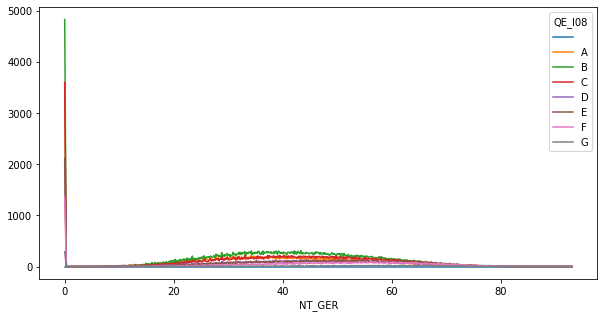

In [12]:
#tmp = pfEnade.groupby(['QE_I08', 'QE_I23'])['NT_GER'].agg(['mean']).unstack() #.where(pfEnade.QE_I08 != ' ')
# MxR = pfEnade.groupby(['NT_GER', 'QE_I08'])['Migrado'].agg(['count']).unstack().where('NT_GER > 0')
MxR = pfEnade.groupby(['NT_GER', 'QE_I08'])['Migrado'].agg(['count']).unstack() #.where(pfEnade.NT_GER > 0)
    
#MxR.index.name = 'Qual a renda total de sua família, incluindo seus rendimentos?'

MxR.columns = MxR.columns.droplevel(0)
#MxR.columns.name = 'Quantas horas por semana, aproximadamente, você dedicou aos estudos, excetuando as horas de aula?'
    
ax = MxR.plot(figsize=(10,5)) 
#ax.set_title('Nota X Renda X Migração', fontsize=20)

# textoRenda = ""
# for key, value in doRendaDIC().items():
#    textoRenda = textoRenda + "{k} : {v}\n".format(k=key, v=value)
#ax.text(0.05, 0.6, textoRenda, transform=ax.transAxes, fontsize=8)

#textoEstudo = ""
#for key, value in doRendaDIC().items():
#    textoEstudo = textoEstudo + "{k} : {v}\n".format(k=key, v=value)
#ax.legend(textoEstudo)